# Deep Convolutional GANs

In this notebook, I'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

I'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: data: File exists


## Getting the data

Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

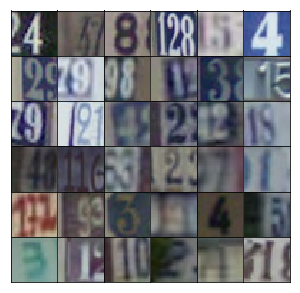

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), self.scaler(y)

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

The input will be our noise vector `z`. The output will be a $tanh$ output with size 32x32 which is the size of our SVHN images.

We'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically we'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now        
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here we'll build the discriminator. This is basically just a convolutional classifier. The input to the discriminator are 32x32x3 tensors/images. The discriminator contains a few convolutional layers, then a fully connected layer for the output. 

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers



In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, 0.5)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other.

In [16]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0004
batch_size = 128
epochs = 10
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/10... Discriminator Loss: 2.6756... Generator Loss: 0.0887
Epoch 1/10... Discriminator Loss: 0.2338... Generator Loss: 13.6529
Epoch 1/10... Discriminator Loss: 0.1273... Generator Loss: 17.3839
Epoch 1/10... Discriminator Loss: 0.1171... Generator Loss: 3.3443
Epoch 1/10... Discriminator Loss: 1.3784... Generator Loss: 1.0097
Epoch 1/10... Discriminator Loss: 1.3116... Generator Loss: 0.6464
Epoch 1/10... Discriminator Loss: 0.8126... Generator Loss: 1.3263
Epoch 1/10... Discriminator Loss: 1.2747... Generator Loss: 1.9335
Epoch 1/10... Discriminator Loss: 0.7344... Generator Loss: 1.3234
Epoch 1/10... Discriminator Loss: 0.7229... Generator Loss: 1.0541


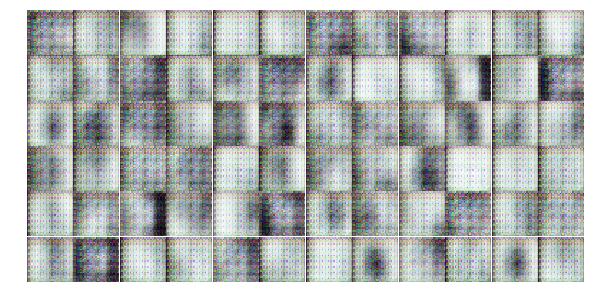

Epoch 1/10... Discriminator Loss: 0.4786... Generator Loss: 1.4291
Epoch 1/10... Discriminator Loss: 0.8126... Generator Loss: 1.1511
Epoch 1/10... Discriminator Loss: 0.9951... Generator Loss: 0.6965
Epoch 1/10... Discriminator Loss: 0.5652... Generator Loss: 1.2924
Epoch 1/10... Discriminator Loss: 0.6762... Generator Loss: 1.5220
Epoch 1/10... Discriminator Loss: 0.5912... Generator Loss: 1.2623
Epoch 1/10... Discriminator Loss: 0.9451... Generator Loss: 0.9713
Epoch 1/10... Discriminator Loss: 1.0819... Generator Loss: 0.7721
Epoch 1/10... Discriminator Loss: 1.2779... Generator Loss: 0.8112
Epoch 1/10... Discriminator Loss: 1.2653... Generator Loss: 1.0713


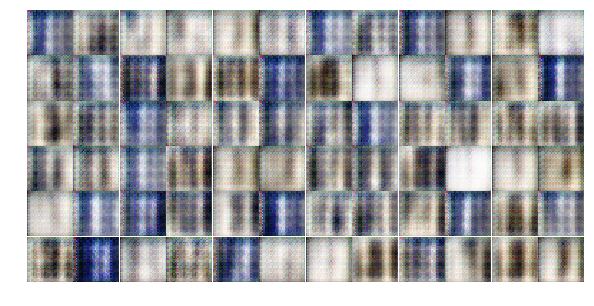

Epoch 1/10... Discriminator Loss: 1.4132... Generator Loss: 0.7099
Epoch 1/10... Discriminator Loss: 1.5776... Generator Loss: 0.9445
Epoch 1/10... Discriminator Loss: 1.2233... Generator Loss: 0.7422
Epoch 1/10... Discriminator Loss: 1.4532... Generator Loss: 0.7006
Epoch 1/10... Discriminator Loss: 1.3650... Generator Loss: 1.5157
Epoch 1/10... Discriminator Loss: 1.5082... Generator Loss: 0.8089
Epoch 1/10... Discriminator Loss: 1.3926... Generator Loss: 0.7089
Epoch 1/10... Discriminator Loss: 1.0046... Generator Loss: 1.0175
Epoch 1/10... Discriminator Loss: 0.9690... Generator Loss: 1.4529
Epoch 1/10... Discriminator Loss: 0.6885... Generator Loss: 2.0427


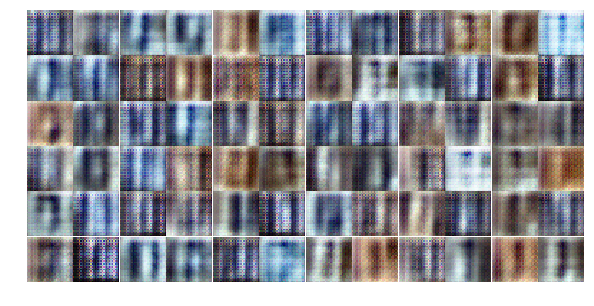

Epoch 1/10... Discriminator Loss: 1.0805... Generator Loss: 0.7439
Epoch 1/10... Discriminator Loss: 1.1277... Generator Loss: 1.2194
Epoch 1/10... Discriminator Loss: 0.9832... Generator Loss: 0.9437
Epoch 1/10... Discriminator Loss: 0.9630... Generator Loss: 1.3362
Epoch 1/10... Discriminator Loss: 1.3730... Generator Loss: 0.6670
Epoch 1/10... Discriminator Loss: 1.1835... Generator Loss: 0.9653
Epoch 1/10... Discriminator Loss: 1.7008... Generator Loss: 0.4615
Epoch 1/10... Discriminator Loss: 1.1932... Generator Loss: 0.9903
Epoch 1/10... Discriminator Loss: 1.1201... Generator Loss: 1.3579
Epoch 1/10... Discriminator Loss: 0.8147... Generator Loss: 1.3127


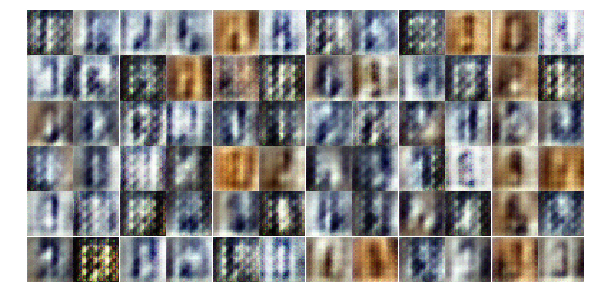

Epoch 1/10... Discriminator Loss: 1.5972... Generator Loss: 0.5448
Epoch 1/10... Discriminator Loss: 0.9001... Generator Loss: 1.7492
Epoch 1/10... Discriminator Loss: 1.2986... Generator Loss: 0.6634
Epoch 1/10... Discriminator Loss: 1.2018... Generator Loss: 1.1620
Epoch 1/10... Discriminator Loss: 1.0529... Generator Loss: 0.9494
Epoch 1/10... Discriminator Loss: 1.1557... Generator Loss: 1.1756
Epoch 1/10... Discriminator Loss: 1.1119... Generator Loss: 0.8325
Epoch 1/10... Discriminator Loss: 1.0837... Generator Loss: 0.9209
Epoch 1/10... Discriminator Loss: 1.5389... Generator Loss: 0.6683
Epoch 1/10... Discriminator Loss: 1.0830... Generator Loss: 0.9181


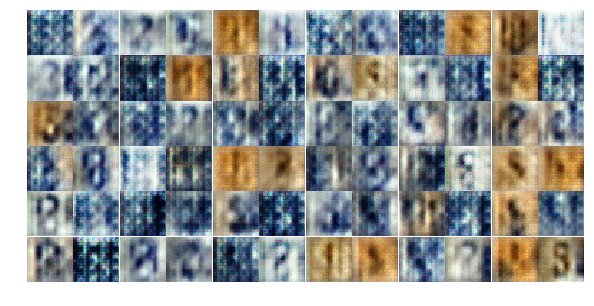

Epoch 1/10... Discriminator Loss: 1.2333... Generator Loss: 1.5571
Epoch 1/10... Discriminator Loss: 1.2340... Generator Loss: 2.5117
Epoch 1/10... Discriminator Loss: 0.9298... Generator Loss: 1.1284
Epoch 1/10... Discriminator Loss: 0.9934... Generator Loss: 1.4168
Epoch 1/10... Discriminator Loss: 0.9870... Generator Loss: 1.0021
Epoch 1/10... Discriminator Loss: 0.6375... Generator Loss: 1.3685
Epoch 1/10... Discriminator Loss: 0.9253... Generator Loss: 1.1377
Epoch 2/10... Discriminator Loss: 1.4117... Generator Loss: 1.3757
Epoch 2/10... Discriminator Loss: 1.3355... Generator Loss: 1.0948
Epoch 2/10... Discriminator Loss: 1.2089... Generator Loss: 0.6923


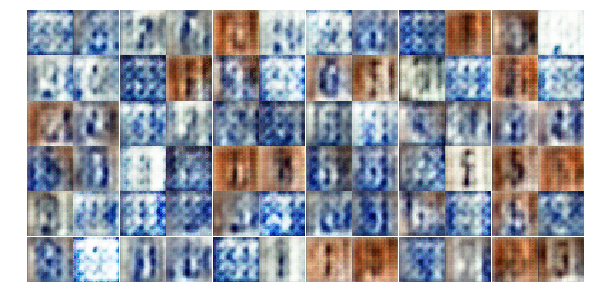

Epoch 2/10... Discriminator Loss: 1.0166... Generator Loss: 1.2979
Epoch 2/10... Discriminator Loss: 1.0587... Generator Loss: 0.8112
Epoch 2/10... Discriminator Loss: 0.9856... Generator Loss: 1.0296
Epoch 2/10... Discriminator Loss: 1.3599... Generator Loss: 2.3837
Epoch 2/10... Discriminator Loss: 1.0388... Generator Loss: 0.7736
Epoch 2/10... Discriminator Loss: 1.0875... Generator Loss: 0.7973
Epoch 2/10... Discriminator Loss: 1.3348... Generator Loss: 1.0844
Epoch 2/10... Discriminator Loss: 0.8543... Generator Loss: 1.1205
Epoch 2/10... Discriminator Loss: 1.0260... Generator Loss: 1.2003
Epoch 2/10... Discriminator Loss: 1.0410... Generator Loss: 0.8460


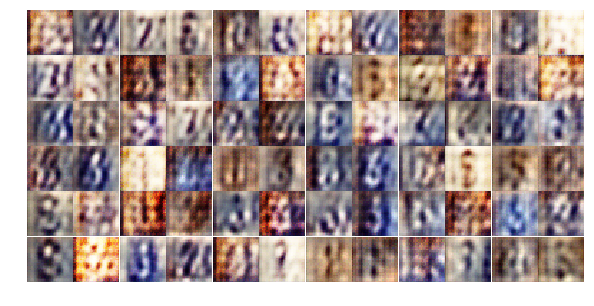

Epoch 2/10... Discriminator Loss: 1.1358... Generator Loss: 1.1739
Epoch 2/10... Discriminator Loss: 1.0514... Generator Loss: 1.2096
Epoch 2/10... Discriminator Loss: 0.9920... Generator Loss: 1.1409
Epoch 2/10... Discriminator Loss: 0.7702... Generator Loss: 1.0264
Epoch 2/10... Discriminator Loss: 1.0245... Generator Loss: 1.4306
Epoch 2/10... Discriminator Loss: 1.1575... Generator Loss: 1.1760
Epoch 2/10... Discriminator Loss: 1.5770... Generator Loss: 0.7415
Epoch 2/10... Discriminator Loss: 1.2622... Generator Loss: 0.8066
Epoch 2/10... Discriminator Loss: 1.3582... Generator Loss: 0.7995
Epoch 2/10... Discriminator Loss: 1.5481... Generator Loss: 0.5074


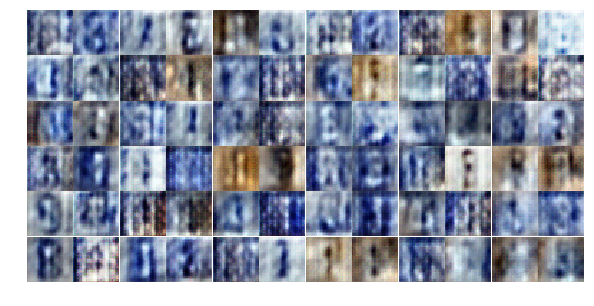

Epoch 2/10... Discriminator Loss: 1.3085... Generator Loss: 0.8164
Epoch 2/10... Discriminator Loss: 1.1947... Generator Loss: 0.9624
Epoch 2/10... Discriminator Loss: 1.1410... Generator Loss: 1.0290
Epoch 2/10... Discriminator Loss: 1.2974... Generator Loss: 0.8149
Epoch 2/10... Discriminator Loss: 1.2395... Generator Loss: 0.8926
Epoch 2/10... Discriminator Loss: 1.0187... Generator Loss: 0.9936
Epoch 2/10... Discriminator Loss: 1.0669... Generator Loss: 1.0235
Epoch 2/10... Discriminator Loss: 1.4930... Generator Loss: 0.5818
Epoch 2/10... Discriminator Loss: 1.3419... Generator Loss: 0.7782
Epoch 2/10... Discriminator Loss: 1.0480... Generator Loss: 0.9835


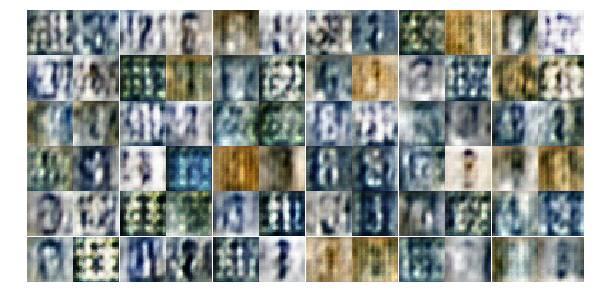

Epoch 2/10... Discriminator Loss: 1.4097... Generator Loss: 0.6013
Epoch 2/10... Discriminator Loss: 1.1187... Generator Loss: 1.1058
Epoch 2/10... Discriminator Loss: 1.2270... Generator Loss: 0.7948
Epoch 2/10... Discriminator Loss: 1.1552... Generator Loss: 0.8996
Epoch 2/10... Discriminator Loss: 1.3286... Generator Loss: 0.6510
Epoch 2/10... Discriminator Loss: 1.4503... Generator Loss: 0.4906
Epoch 2/10... Discriminator Loss: 0.9291... Generator Loss: 1.2756
Epoch 2/10... Discriminator Loss: 1.0785... Generator Loss: 1.1645
Epoch 2/10... Discriminator Loss: 1.2225... Generator Loss: 0.7723
Epoch 2/10... Discriminator Loss: 0.9404... Generator Loss: 1.5439


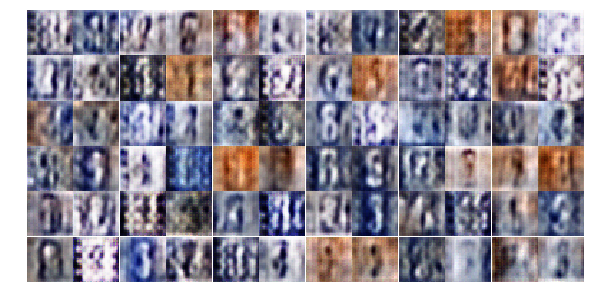

Epoch 2/10... Discriminator Loss: 1.4546... Generator Loss: 0.6666
Epoch 2/10... Discriminator Loss: 1.0837... Generator Loss: 1.3144
Epoch 2/10... Discriminator Loss: 0.7208... Generator Loss: 1.2828
Epoch 2/10... Discriminator Loss: 1.2148... Generator Loss: 1.0794
Epoch 2/10... Discriminator Loss: 1.1563... Generator Loss: 0.7683
Epoch 2/10... Discriminator Loss: 0.7954... Generator Loss: 1.2402
Epoch 2/10... Discriminator Loss: 1.3895... Generator Loss: 1.2752
Epoch 2/10... Discriminator Loss: 1.3519... Generator Loss: 0.8686
Epoch 2/10... Discriminator Loss: 1.0182... Generator Loss: 1.2454
Epoch 2/10... Discriminator Loss: 0.9667... Generator Loss: 1.3313


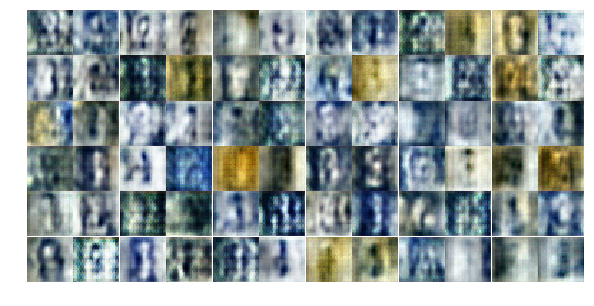

Epoch 2/10... Discriminator Loss: 1.0572... Generator Loss: 0.8748
Epoch 2/10... Discriminator Loss: 0.9993... Generator Loss: 0.6791
Epoch 2/10... Discriminator Loss: 1.4160... Generator Loss: 0.7163
Epoch 2/10... Discriminator Loss: 1.5020... Generator Loss: 0.5380
Epoch 3/10... Discriminator Loss: 1.3711... Generator Loss: 0.9834
Epoch 3/10... Discriminator Loss: 0.9191... Generator Loss: 1.1181
Epoch 3/10... Discriminator Loss: 0.8909... Generator Loss: 1.0661
Epoch 3/10... Discriminator Loss: 1.0297... Generator Loss: 0.8184
Epoch 3/10... Discriminator Loss: 1.1506... Generator Loss: 0.8057
Epoch 3/10... Discriminator Loss: 1.2655... Generator Loss: 1.1834


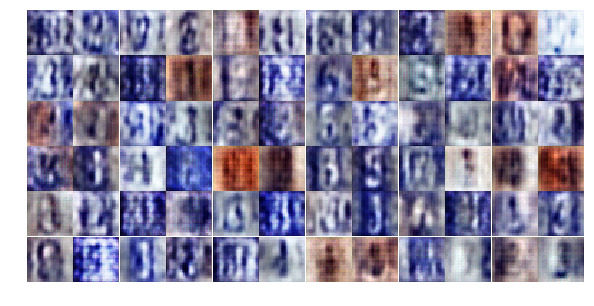

Epoch 3/10... Discriminator Loss: 0.6340... Generator Loss: 1.5986
Epoch 3/10... Discriminator Loss: 1.5759... Generator Loss: 1.5996
Epoch 3/10... Discriminator Loss: 1.2724... Generator Loss: 0.8905
Epoch 3/10... Discriminator Loss: 0.9645... Generator Loss: 0.9248
Epoch 3/10... Discriminator Loss: 1.0173... Generator Loss: 1.7493
Epoch 3/10... Discriminator Loss: 1.0854... Generator Loss: 0.8460
Epoch 3/10... Discriminator Loss: 1.2528... Generator Loss: 0.8408
Epoch 3/10... Discriminator Loss: 1.1898... Generator Loss: 0.5708
Epoch 3/10... Discriminator Loss: 0.9821... Generator Loss: 1.1928
Epoch 3/10... Discriminator Loss: 1.2606... Generator Loss: 0.5035


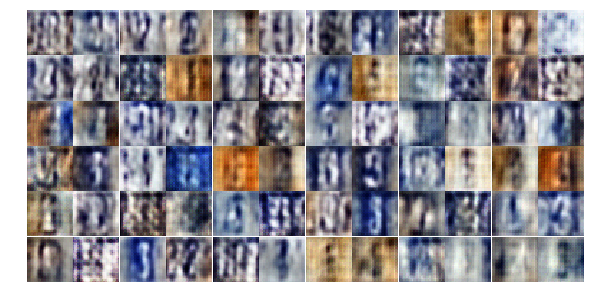

Epoch 3/10... Discriminator Loss: 1.2727... Generator Loss: 0.7251
Epoch 3/10... Discriminator Loss: 0.8119... Generator Loss: 1.0596
Epoch 3/10... Discriminator Loss: 0.9372... Generator Loss: 0.8313
Epoch 3/10... Discriminator Loss: 1.0195... Generator Loss: 0.9939
Epoch 3/10... Discriminator Loss: 0.6421... Generator Loss: 1.6837
Epoch 3/10... Discriminator Loss: 0.8557... Generator Loss: 0.9059
Epoch 3/10... Discriminator Loss: 0.8637... Generator Loss: 0.7705
Epoch 3/10... Discriminator Loss: 0.9512... Generator Loss: 0.7807
Epoch 3/10... Discriminator Loss: 1.0035... Generator Loss: 0.8186
Epoch 3/10... Discriminator Loss: 0.9312... Generator Loss: 0.9084


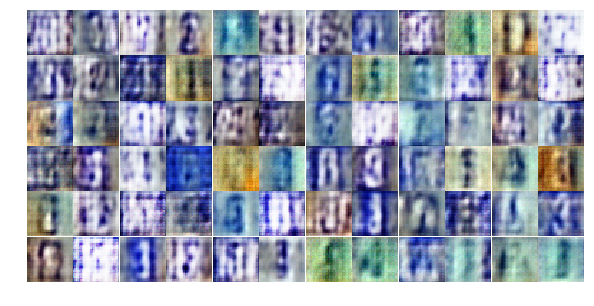

Epoch 3/10... Discriminator Loss: 0.7056... Generator Loss: 1.4795
Epoch 3/10... Discriminator Loss: 1.3704... Generator Loss: 1.6386
Epoch 3/10... Discriminator Loss: 1.0708... Generator Loss: 1.1681
Epoch 3/10... Discriminator Loss: 1.3846... Generator Loss: 0.4818
Epoch 3/10... Discriminator Loss: 0.6581... Generator Loss: 1.4868
Epoch 3/10... Discriminator Loss: 0.9587... Generator Loss: 0.7720
Epoch 3/10... Discriminator Loss: 0.9357... Generator Loss: 1.5476
Epoch 3/10... Discriminator Loss: 0.8718... Generator Loss: 1.5045
Epoch 3/10... Discriminator Loss: 0.9991... Generator Loss: 1.0107
Epoch 3/10... Discriminator Loss: 0.8704... Generator Loss: 0.8618


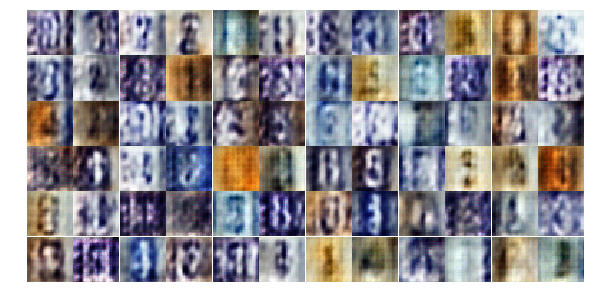

Epoch 3/10... Discriminator Loss: 0.7727... Generator Loss: 1.5832
Epoch 3/10... Discriminator Loss: 1.0856... Generator Loss: 1.2824
Epoch 3/10... Discriminator Loss: 0.9514... Generator Loss: 0.8969
Epoch 3/10... Discriminator Loss: 0.8332... Generator Loss: 2.0440
Epoch 3/10... Discriminator Loss: 0.6853... Generator Loss: 1.8570
Epoch 3/10... Discriminator Loss: 0.6844... Generator Loss: 1.1425
Epoch 3/10... Discriminator Loss: 1.2105... Generator Loss: 0.5379
Epoch 3/10... Discriminator Loss: 1.0633... Generator Loss: 0.6998
Epoch 3/10... Discriminator Loss: 1.1041... Generator Loss: 0.6420
Epoch 3/10... Discriminator Loss: 1.0651... Generator Loss: 1.4487


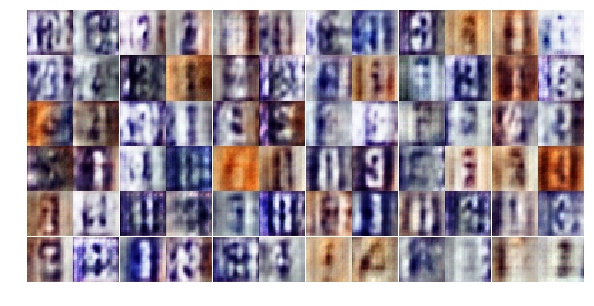

Epoch 3/10... Discriminator Loss: 1.0156... Generator Loss: 0.7475
Epoch 3/10... Discriminator Loss: 1.0097... Generator Loss: 0.8487
Epoch 3/10... Discriminator Loss: 0.9134... Generator Loss: 0.8934
Epoch 3/10... Discriminator Loss: 0.7157... Generator Loss: 1.2197
Epoch 3/10... Discriminator Loss: 0.5516... Generator Loss: 1.9426
Epoch 3/10... Discriminator Loss: 0.8463... Generator Loss: 0.9700
Epoch 3/10... Discriminator Loss: 1.3237... Generator Loss: 0.4794
Epoch 3/10... Discriminator Loss: 0.5686... Generator Loss: 1.7231
Epoch 3/10... Discriminator Loss: 0.9070... Generator Loss: 0.9589
Epoch 3/10... Discriminator Loss: 0.5486... Generator Loss: 1.5761


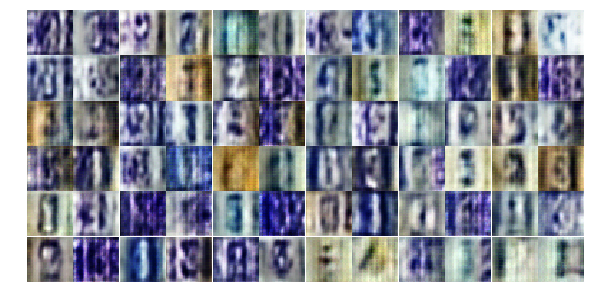

Epoch 3/10... Discriminator Loss: 1.0592... Generator Loss: 0.7174
Epoch 4/10... Discriminator Loss: 0.6093... Generator Loss: 1.5914
Epoch 4/10... Discriminator Loss: 0.9227... Generator Loss: 2.2135


KeyboardInterrupt: 

In [17]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))